In [187]:
# import

import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# download data

!wget -P /Volumes/Elements/Hackathons/ML-zoomcamp/data/ https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-09-29 16:09:58--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘/Volumes/Elements/Hackathons/ML-zoomcamp/data/AB_NYC_2019.csv.1’

AB_NYC_2019.csv.1   100%[===================>]   6.75M  4.73MB/s    in 1.4s    

2021-09-29 16:09:59 (4.73 MB/s) - ‘/Volumes/Elements/Hackathons/ML-zoomcamp/data/AB_NYC_2019.csv.1’ saved [7077973/7077973]



## EDA

Load the data.
Look at the price variable. Does it have a long tail?

In [50]:
# load data

data = pd.read_csv('../data/AB_NYC_2019.csv')

In [51]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


<AxesSubplot:>

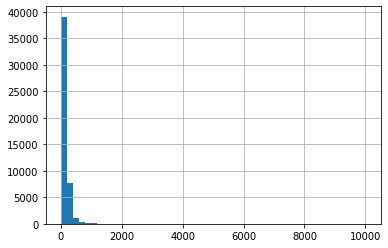

In [52]:
# price variable

data['price'].hist(bins=50)

## Features

In [53]:
features = ['latitude','longitude','price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365'
]

In [62]:
df = data[features]

## Question 1

Find a feature with missing values. How many missing values does it have?

In [22]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [23]:
df['minimum_nights'].median()

3.0

## Split the data

Shuffle the initial dataset, use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Make sure that the target value ('price') is not in your dataframe.
Apply the log transformation to the price variable using the np.log1p() function.

In [63]:
# shuffle dataset

df = df.sample(frac=1, random_state = 42).reset_index(drop=True)

In [43]:
# train-valid-test split

n_sample = df.shape[0]
train_index = int(0.6 * n_sample)
val_index = train_index + int(0.2 * n_sample)
test_index = val_index + int(0.2 * n_sample)

In [71]:
# target
y = df.price.values

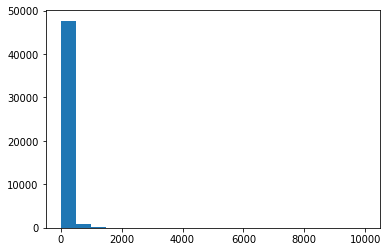

In [93]:
plt.hist(y, bins =20)
plt.show()

In [94]:
# clip values above 1000

y1 = [1000 if val > 1000 else val for val in y]

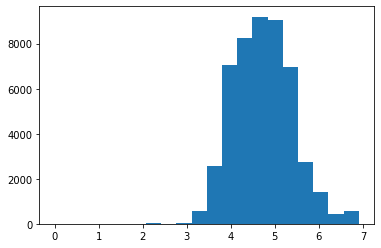

In [95]:
# log transformation

y1_ = np.log1p(y1)
plt.hist(y1_, bins=20)
plt.show()

In [58]:
del df['price']

In [185]:
for idx in [train_index, val_index, test_index]:
    
    X_train, y_train = df.iloc[:train_index], y1_[:train_index]
    X_val, y_val = df.iloc[train_index:val_index], y1_[train_index:val_index]
    X_test, y_test = df.iloc[val_index:test_index], y1_[val_index:test_index]

In [143]:
len(X_train) + len(X_val)+ len(X_test)

48895

## Question 3

We need to deal with missing values for the column from Q1.
We have two options: fill it with 0 or with the mean of this variable.
Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!
Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

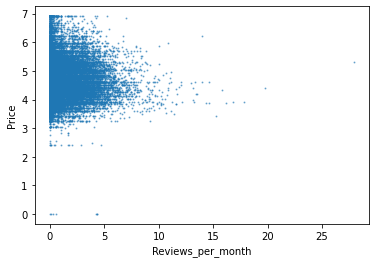

In [186]:
# How important is reviews_per_month feature to predict price?

plt.scatter(X_train['reviews_per_month'], y_train, s = 1, alpha = 0.5)
plt.xlabel('Reviews_per_month')
plt.ylabel('Price')
plt.show()

In [148]:
# fill Nan with 0

for X in [X_train, X_val, X_test]:
    X['reviews_per_month'].fillna(0, inplace = True)

/Applications/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [102]:
# linear regression

def linear_regression(X, y):
    
    X_ones = np.ones(X.shape[0])
    X = np.column_stack((X_ones, X))
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]
    

In [149]:
w0, w = linear_regression(X_train, y_train)

In [150]:
# validation
y_pred = w0 + X_val.dot(w)

In [118]:
# RMSE

def RMSE (y_pred, y_true):
    err = y_true - y_pred
    squared_err = err**2.
    mse = np.mean(squared_err)
    rmse = np.sqrt(mse)
    
    return rmse

In [157]:
round(RMSE(y_pred, y_val),2)

0.53

In [152]:
# fill Nan with mean value

for X in [X_train, X_val, X_test]:
    val = X['reviews_per_month'].mean()
    X['reviews_per_month'].fillna(val, inplace = True)

In [153]:
# linear regression
w0, w = linear_regression(X_train, y_train)

In [154]:
# validation
y_pred = w0 + X_val.dot(w)

In [156]:
round(RMSE(y_pred, y_val),2)

0.53

Both the methods are equally good as measured using RMSE

## Question 4

Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

In [158]:
# regularization parameter
r = [0, 1e-6, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10]

In [178]:
def prepare_X (X, fillna_val, r):
    
    X['reviews_per_month'].fillna(fillna_val, inplace=True)
    X = X + np.eye(N = X.shape[0], M = X.shape[1]) *r
    
    return X

In [190]:
for val in r:
    X_train = prepare_X(X_train, 0, val)
    X_val = prepare_X(X_val, 0, val)
    
    w0, w = linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    rmse = round(RMSE(y_pred, y_val),2)
    
    print ('r:', val, 'RMSE:', rmse)
    

r: 0 RMSE: 0.52
r: 1e-06 RMSE: 0.52
r: 0.0001 RMSE: 0.52
r: 0.001 RMSE: 0.52
r: 0.01 RMSE: 0.52
r: 0.1 RMSE: 0.52
r: 1 RMSE: 0.52
r: 5 RMSE: 0.54
r: 10 RMSE: 0.55


Since for regularization parameters 0 to 0.1, the RMSE score is comparable, the least value is chosen. r =0.

## Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))


In [189]:
seeds =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for seed in seeds:
    
    df = data[features].copy()
    
    # train test split
    df = df.sample(frac=1, random_state = seed).reset_index(drop=True)
    n_sample = df.shape[0]
    train_index = int(0.6 * n_sample)
    val_index = train_index + int(0.2 * n_sample)
    test_index = val_index + int(0.2 * n_sample)
    
    # target
    y = df.price.values
    y1 = [1000 if val > 1000 else val for val in y]
    y1_ = np.log1p(y1)
    
    for idx in [train_index, val_index, test_index]:
        X_train, y_train = df.iloc[:train_index], y1_[:train_index]
        X_val, y_val = df.iloc[train_index:val_index], y1_[train_index:val_index]
        X_test, y_test = df.iloc[val_index:test_index], y1_[val_index:test_index]
        
        # fill Nan with 0

    for X in [X_train, X_val, X_test]:
        X['reviews_per_month'].fillna(0, inplace = True)
    
    w0, w = linear_regression(X_train, y_train)
    
    # validation
    y_pred = w0 + X_val.dot(w)
    
    # RMSE
    score = round(RMSE(y_pred, y_val),3)
    scores.append(score)
    
    print('SEED:', seed, 'RMSE:',score) 

print('*'*20)
print('std of rmse:',round(np.std(scores),3))


SEED: 0 RMSE: 0.531
SEED: 1 RMSE: 0.573
SEED: 2 RMSE: 0.532
SEED: 3 RMSE: 0.554
SEED: 4 RMSE: 0.514
SEED: 5 RMSE: 0.51
SEED: 6 RMSE: 0.505
SEED: 7 RMSE: 0.5
SEED: 8 RMSE: 0.556
SEED: 9 RMSE: 0.518
********************
std of rmse: 0.023


## Question 6

Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [193]:
df = data[features].copy()

# train test split
seed = 9
df = df.sample(frac=1, random_state = seed).reset_index(drop=True)

n_sample = df.shape[0]
train_index = int(0.8 * n_sample)

# target
y = df.price.values
y1 = [1000 if val > 1000 else val for val in y]
y1_ = np.log1p(y1)

X_train, y_train = df.iloc[:train_index], y1_[:train_index]
X_test, y_test = df.iloc[train_index:], y1_[train_index:]

# fill Nan with 0
for X in [X_train, X_test]:
    X = prepare_X(X,0,1e-3)
    
w0, w = linear_regression(X_train, y_train)

# validation
y_pred = w0 + X_test.dot(w)

# RMSE
score = round(RMSE(y_pred, y_test),3)
print('test score:', score)

test score: 0.541
